## Report at the bottom of notebook

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

In [118]:
df = pd.read_csv("../input/bank-note-authentication-uci-data/BankNote_Authentication.csv")

In [30]:
df['class'].value_counts()

class
0    762
1    610
Name: count, dtype: int64

In [31]:
df.isna().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

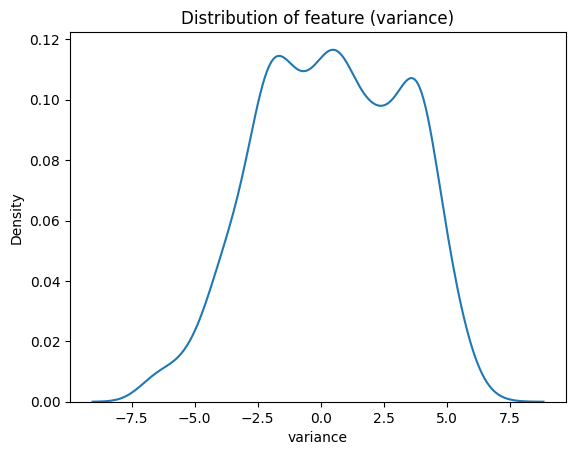

In [32]:
sns.kdeplot(data=df, x='variance')

plt.title('Distribution of feature (variance)')
plt.show()

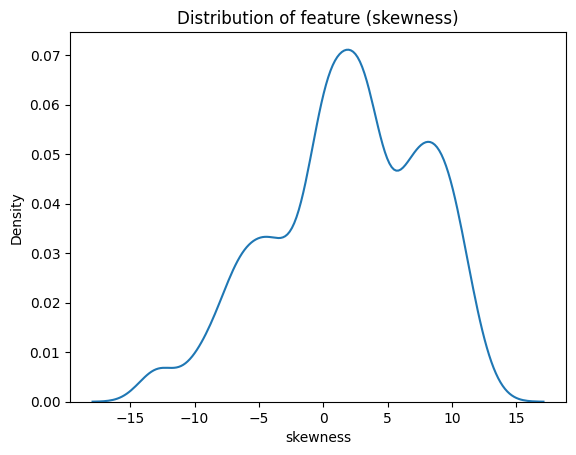

In [33]:
sns.kdeplot(data=df, x='skewness')

plt.title('Distribution of feature (skewness)')
plt.show()

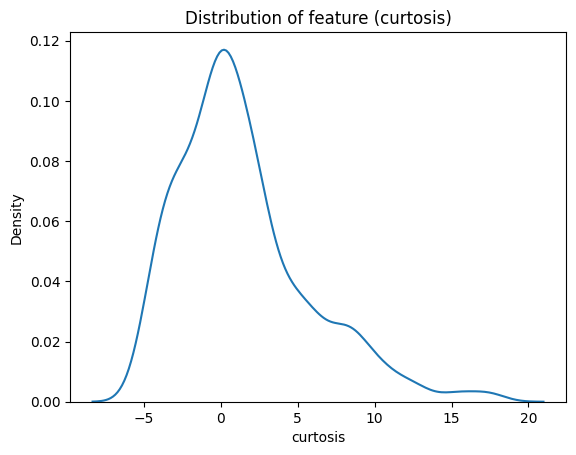

In [34]:
sns.kdeplot(data=df, x='curtosis')

plt.title('Distribution of feature (curtosis)')
plt.show()

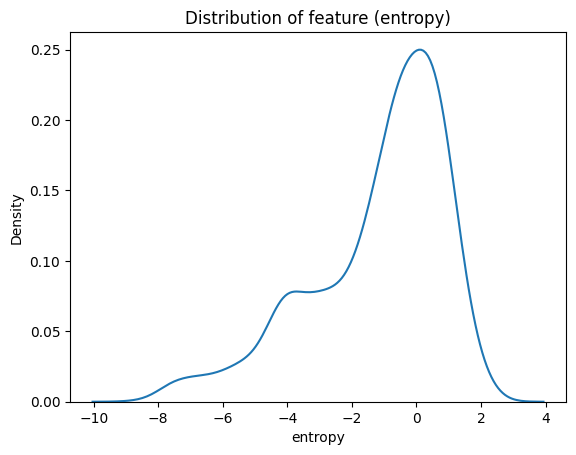

In [35]:
sns.kdeplot(data=df, x='entropy')

plt.title('Distribution of feature (entropy)')
plt.show()

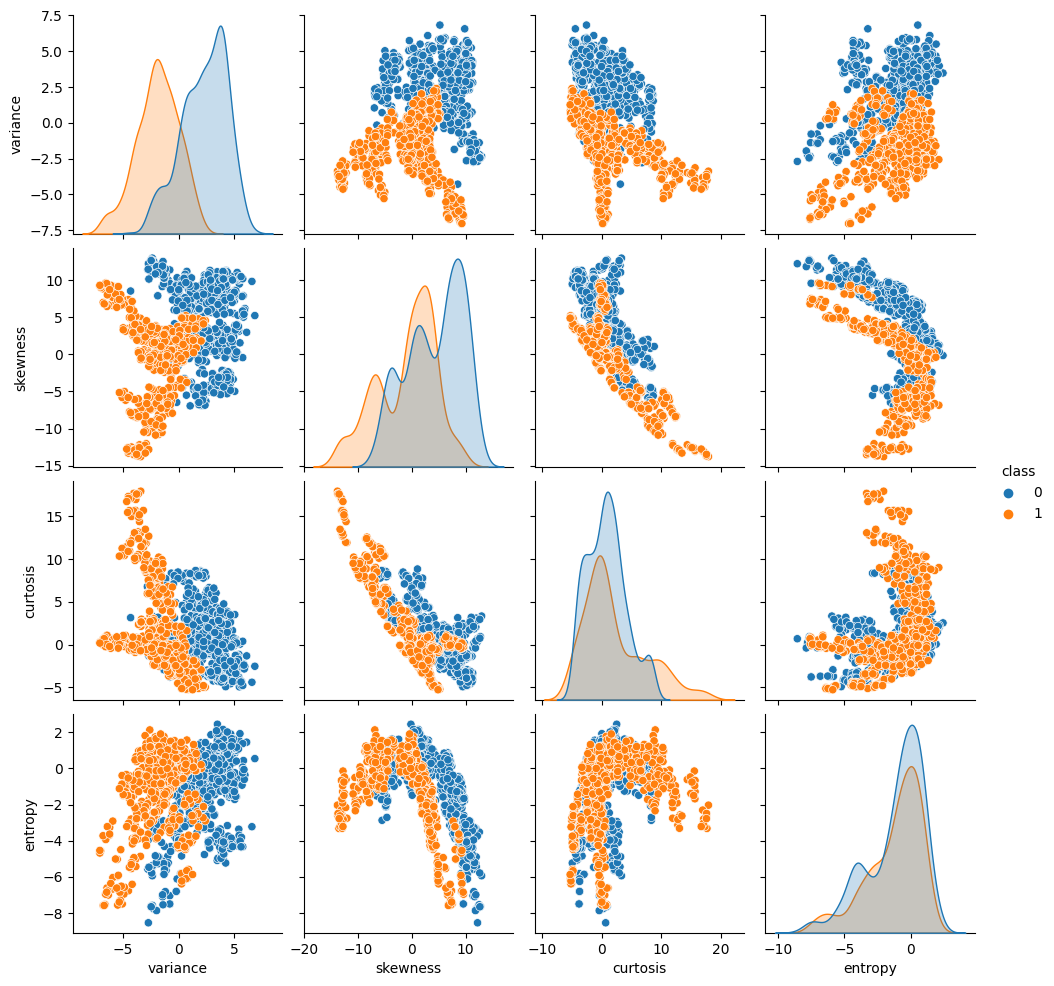

In [37]:
sns.pairplot(df, hue="class")

<Axes: >

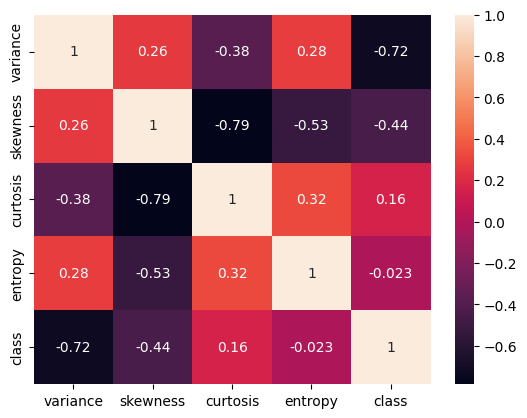

In [38]:
sns.heatmap(df.corr(), annot=True)

In [39]:
columns = list(df.columns)
columns.remove('class')

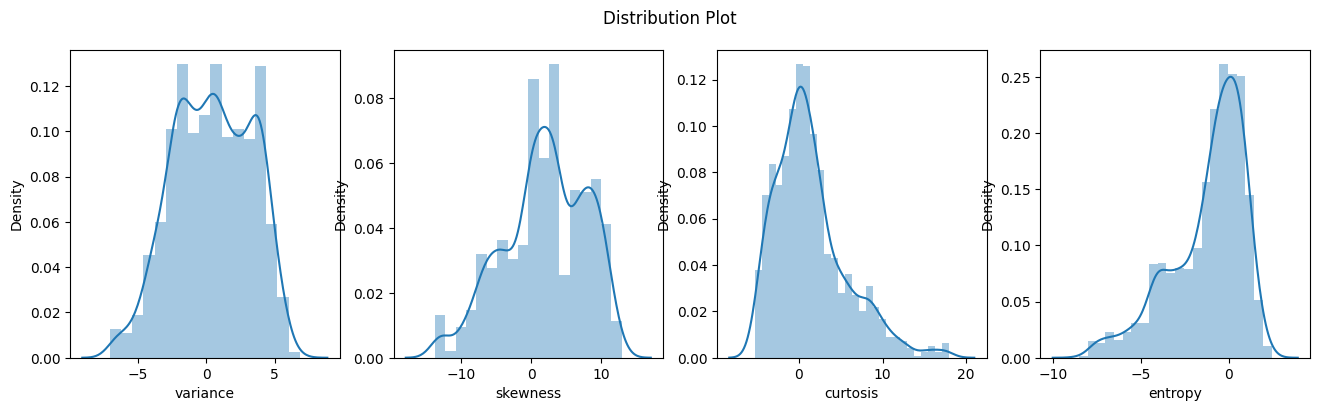

In [40]:
fig, ax = plt.subplots(ncols = 4, figsize=(16, 4))
fig.suptitle("Distribution Plot")

for index, column in enumerate(columns):
    sns.distplot(df[column], ax=ax[index])

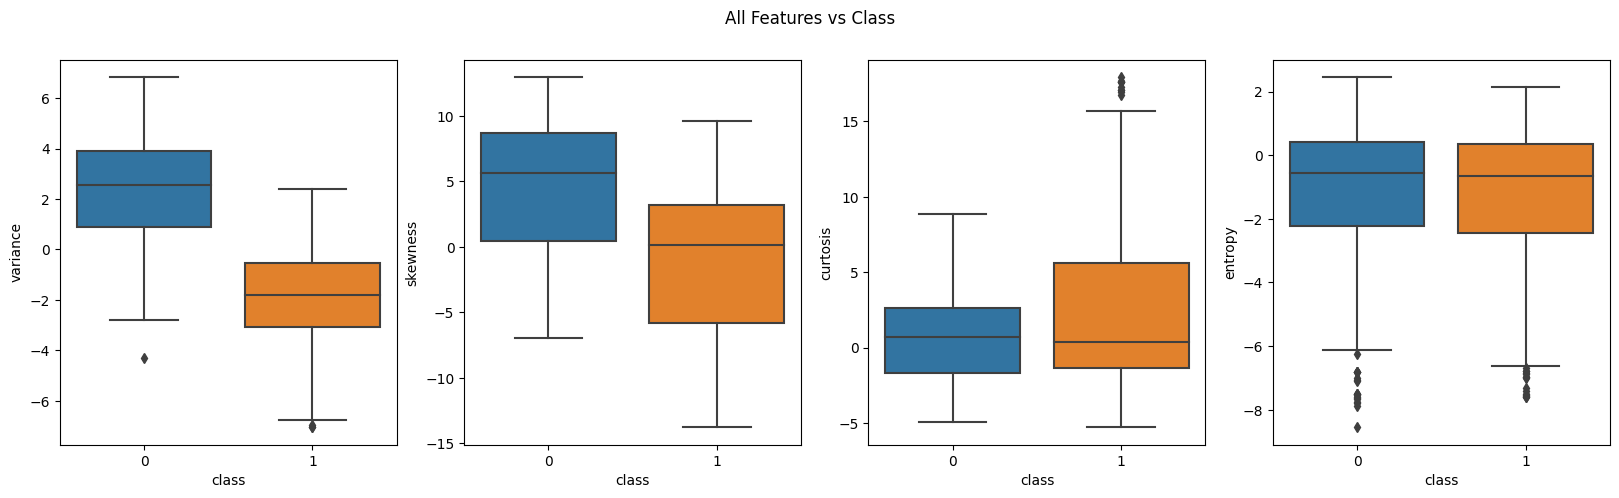

In [41]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
fig.suptitle("All Features vs Class")

for index, column in enumerate(columns):
    sns.boxplot(x="class", y=column, data=df, ax=ax[index])

In [119]:
df['variance'] = pd.qcut(df['variance'], q=10, labels=['variance_Q1', 'variance_Q2', 'variance_Q3', 'variance_Q4', 'variance_Q5', 
                                                       'variance_Q6', 'variance_Q7', 'variance_Q8', 'variance_Q9', 'variance_Q10'])
df['skewness'] = pd.qcut(df['skewness'], q=10, labels=['skewness_Q1', 'skewness_Q2', 'skewness_Q3', 'skewness_Q4', 'skewness_Q5', 
                                                      'skewness_Q6', 'skewness_Q7', 'skewness_Q8', 'skewness_Q9', 'skewness_Q10'])
df['curtosis'] = pd.qcut(df['curtosis'], q=10, labels=['curtosis_Q1', 'curtosis_Q2', 'curtosis_Q3', 'curtosis_Q4', 'curtosis_Q5', 
                                                      'curtosis_Q6', 'curtosis_Q7', 'curtosis_Q8', 'curtosis_Q9', 'curtosis_Q10'])
df['entropy'] = pd.qcut(df['entropy'], q=10, labels=['entropy_Q1', 'entropy_Q2', 'entropy_Q3', 'entropy_Q4', 'entropy_Q5',
                                                    'entropy_Q6', 'entropy_Q7', 'entropy_Q8', 'entropy_Q9', 'entropy_Q10'])

In [121]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int)

df_encoded = ohe.fit_transform(df.drop(columns=['class']))

feature_names = ohe.get_feature_names_out(input_features=df.drop(columns=['class']).columns)

df_final = pd.DataFrame(df_encoded, columns=feature_names, index=df.drop(columns=['class']).index)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(df_final, df['class'], stratify=df['class'], test_size=0.2, random_state=42)

In [129]:
#Implement FCA lazy classification
def classify_fca_lazy(train_pos, train_neg, test_obj, min_cardinality=2, max_counter_examples=1):
    pos_counter = 0
    neg_counter = 0

    # Check intersections with positive examples
    for _, pos_obj in train_pos.iterrows():
        intersection = pos_obj & test_obj
        if any((intersection & train_neg).all(axis=1)):
            pos_counter += 1
        if intersection.sum() < min_cardinality:
            pos_counter += 1

    # Check intersections with negative examples
    for _, neg_obj in train_neg.iterrows():
        intersection = neg_obj & test_obj
        if any((intersection & train_pos).all(axis=1)):
            neg_counter += 1
        if intersection.sum() < min_cardinality:
            neg_counter += 1

    # Assign class based on counters
    return 1 if pos_counter <= max_counter_examples and neg_counter > max_counter_examples else 0

# Prepare positive and negative contexts
train_pos = X_train[y_train == '1']
train_neg = X_train[y_train == '0']

# Classify test examples
test_predictions = []
for _, test_obj in X_test.iterrows():
    prediction = classify_fca_lazy(train_pos, train_neg, test_obj)
    test_predictions.append(prediction)

#Evaluate performance
conf_matrix = confusion_matrix(y_test, test_predictions)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
npv = tn / (tn + fn)
fpr = fp / (fp + tn)
fdr = fp / (fp + tp)
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)
print("Negative Predictive Value:", npv)
print("False Positive Rate:", fpr)
print("False Discovery Rate:", fdr)

#Report generation
report = {
    "Confusion Matrix": conf_matrix.tolist(),
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Specificity": specificity,
    "Negative Predictive Value": npv,
    "False Positive Rate": fpr,
    "False Discovery Rate": fdr,
}
print("\nReport:\n", report)

Confusion Matrix:
 [[153   0]
 [122   0]]
Accuracy: 0.5563636363636364
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Specificity: 1.0
Negative Predictive Value: 0.5563636363636364
False Positive Rate: 0.0
False Discovery Rate: nan

Report:
 {'Confusion Matrix': [[153, 0], [122, 0]], 'Accuracy': 0.5563636363636364, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'Specificity': 1.0, 'Negative Predictive Value': 0.5563636363636364, 'False Positive Rate': 0.0, 'False Discovery Rate': nan}


In [131]:
#kNN model
k = 5 
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

test_predictions_knn = knn_model.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, test_predictions_knn)
tn, fp, fn, tp = conf_matrix_knn.ravel()

# Safe division to avoid division by zero when calculating metrics
def safe_divide(numerator, denominator):
    return numerator / denominator if denominator != 0 else 0

# Calculate metrics
specificity_knn = safe_divide(tn, (tn + fp))
npv_knn = safe_divide(tn, (tn + fn))
fpr_knn = safe_divide(fp, (fp + tn))
fdr_knn = safe_divide(fp, (fp + tp))
accuracy_knn = accuracy_score(y_test, test_predictions_knn)
precision_knn = precision_score(y_test, test_predictions_knn)
recall_knn = recall_score(y_test, test_predictions_knn)
f1_knn = f1_score(y_test, test_predictions_knn)

print("Confusion Matrix (kNN):\n", conf_matrix_knn)
print("Accuracy (kNN):", accuracy_knn)
print("Precision (kNN):", precision_knn)
print("Recall (kNN):", recall_knn)
print("F1 Score (kNN):", f1_knn)
print("Specificity (kNN):", specificity_knn)
print("Negative Predictive Value (kNN):", npv_knn)
print("False Positive Rate (kNN):", fpr_knn)
print("False Discovery Rate (kNN):", fdr_knn)

report_knn = {
    "Confusion Matrix": conf_matrix_knn.tolist(),
    "Accuracy": accuracy_knn,
    "Precision": precision_knn,
    "Recall": recall_knn,
    "F1 Score": f1_knn,
    "Specificity": specificity_knn,
    "Negative Predictive Value": npv_knn,
    "False Positive Rate": fpr_knn,
    "False Discovery Rate": fdr_knn,
}
print("\nReport (kNN):\n", report_knn)

Confusion Matrix (kNN):
 [[145   8]
 [  4 118]]
Accuracy (kNN): 0.9563636363636364
Precision (kNN): 0.9365079365079365
Recall (kNN): 0.9672131147540983
F1 Score (kNN): 0.9516129032258064
Specificity (kNN): 0.9477124183006536
Negative Predictive Value (kNN): 0.9731543624161074
False Positive Rate (kNN): 0.05228758169934641
False Discovery Rate (kNN): 0.06349206349206349

Report (kNN):
 {'Confusion Matrix': [[145, 8], [4, 118]], 'Accuracy': 0.9563636363636364, 'Precision': 0.9365079365079365, 'Recall': 0.9672131147540983, 'F1 Score': 0.9516129032258064, 'Specificity': 0.9477124183006536, 'Negative Predictive Value': 0.9731543624161074, 'False Positive Rate': 0.05228758169934641, 'False Discovery Rate': 0.06349206349206349}


In [132]:
#Naive Bayes model
nb_model = BernoulliNB()
nb_model.fit(X_train, y_train)

test_predictions_nb = nb_model.predict(X_test)

conf_matrix_nb = confusion_matrix(y_test, test_predictions_nb)
tn, fp, fn, tp = conf_matrix_nb.ravel()

specificity_nb = safe_divide(tn, (tn + fp))
npv_nb = safe_divide(tn, (tn + fn))
fpr_nb = safe_divide(fp, (fp + tn))
fdr_nb = safe_divide(fp, (fp + tp))
accuracy_nb = accuracy_score(y_test, test_predictions_nb)
precision_nb = precision_score(y_test, test_predictions_nb)
recall_nb = recall_score(y_test, test_predictions_nb)
f1_nb = f1_score(y_test, test_predictions_nb)

print("Confusion Matrix (Naive Bayes):\n", conf_matrix_nb)
print("Accuracy (Naive Bayes):", accuracy_nb)
print("Precision (Naive Bayes):", precision_nb)
print("Recall (Naive Bayes):", recall_nb)
print("F1 Score (Naive Bayes):", f1_nb)
print("Specificity (Naive Bayes):", specificity_nb)
print("Negative Predictive Value (Naive Bayes):", npv_nb)
print("False Positive Rate (Naive Bayes):", fpr_nb)
print("False Discovery Rate (Naive Bayes):", fdr_nb)

report_nb = {
    "Confusion Matrix": conf_matrix_nb.tolist(),
    "Accuracy": accuracy_nb,
    "Precision": precision_nb,
    "Recall": recall_nb,
    "F1 Score": f1_nb,
    "Specificity": specificity_nb,
    "Negative Predictive Value": npv_nb,
    "False Positive Rate": fpr_nb,
    "False Discovery Rate": fdr_nb,
}
print("\nReport (Naive Bayes):\n", report_nb)

Confusion Matrix (Naive Bayes):
 [[139  14]
 [ 12 110]]
Accuracy (Naive Bayes): 0.9054545454545454
Precision (Naive Bayes): 0.8870967741935484
Recall (Naive Bayes): 0.9016393442622951
F1 Score (Naive Bayes): 0.8943089430894309
Specificity (Naive Bayes): 0.9084967320261438
Negative Predictive Value (Naive Bayes): 0.9205298013245033
False Positive Rate (Naive Bayes): 0.0915032679738562
False Discovery Rate (Naive Bayes): 0.11290322580645161

Report (Naive Bayes):
 {'Confusion Matrix': [[139, 14], [12, 110]], 'Accuracy': 0.9054545454545454, 'Precision': 0.8870967741935484, 'Recall': 0.9016393442622951, 'F1 Score': 0.8943089430894309, 'Specificity': 0.9084967320261438, 'Negative Predictive Value': 0.9205298013245033, 'False Positive Rate': 0.0915032679738562, 'False Discovery Rate': 0.11290322580645161}


In [133]:
#Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)

test_predictions_logistic = logistic_model.predict(X_test)

conf_matrix_logistic = confusion_matrix(y_test, test_predictions_logistic)
tn, fp, fn, tp = conf_matrix_logistic.ravel()

specificity_logistic = safe_divide(tn, (tn + fp))
npv_logistic = safe_divide(tn, (tn + fn))
fpr_logistic = safe_divide(fp, (fp + tn))
fdr_logistic = safe_divide(fp, (fp + tp))
accuracy_logistic = accuracy_score(y_test, test_predictions_logistic)
precision_logistic = precision_score(y_test, test_predictions_logistic)
recall_logistic = recall_score(y_test, test_predictions_logistic)
f1_logistic = f1_score(y_test, test_predictions_logistic)

print("Confusion Matrix (Logistic Regression):\n", conf_matrix_logistic)
print("Accuracy (Logistic Regression):", accuracy_logistic)
print("Precision (Logistic Regression):", precision_logistic)
print("Recall (Logistic Regression):", recall_logistic)
print("F1 Score (Logistic Regression):", f1_logistic)
print("Specificity (Logistic Regression):", specificity_logistic)
print("Negative Predictive Value (Logistic Regression):", npv_logistic)
print("False Positive Rate (Logistic Regression):", fpr_logistic)
print("False Discovery Rate (Logistic Regression):", fdr_logistic)

report_logistic = {
    "Confusion Matrix": conf_matrix_logistic.tolist(),
    "Accuracy": accuracy_logistic,
    "Precision": precision_logistic,
    "Recall": recall_logistic,
    "F1 Score": f1_logistic,
    "Specificity": specificity_logistic,
    "Negative Predictive Value": npv_logistic,
    "False Positive Rate": fpr_logistic,
    "False Discovery Rate": fdr_logistic,
}
print("\nReport (Logistic Regression):\n", report_logistic)

Confusion Matrix (Logistic Regression):
 [[147   6]
 [  0 122]]
Accuracy (Logistic Regression): 0.9781818181818182
Precision (Logistic Regression): 0.953125
Recall (Logistic Regression): 1.0
F1 Score (Logistic Regression): 0.976
Specificity (Logistic Regression): 0.9607843137254902
Negative Predictive Value (Logistic Regression): 1.0
False Positive Rate (Logistic Regression): 0.0392156862745098
False Discovery Rate (Logistic Regression): 0.046875

Report (Logistic Regression):
 {'Confusion Matrix': [[147, 6], [0, 122]], 'Accuracy': 0.9781818181818182, 'Precision': 0.953125, 'Recall': 1.0, 'F1 Score': 0.976, 'Specificity': 0.9607843137254902, 'Negative Predictive Value': 1.0, 'False Positive Rate': 0.0392156862745098, 'False Discovery Rate': 0.046875}


In [134]:
#SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can try other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

test_predictions_svm = svm_model.predict(X_test)

conf_matrix_svm = confusion_matrix(y_test, test_predictions_svm)
tn, fp, fn, tp = conf_matrix_svm.ravel()

specificity_svm = safe_divide(tn, (tn + fp))
npv_svm = safe_divide(tn, (tn + fn))
fpr_svm = safe_divide(fp, (fp + tn))
fdr_svm = safe_divide(fp, (fp + tp))
accuracy_svm = accuracy_score(y_test, test_predictions_svm)
precision_svm = precision_score(y_test, test_predictions_svm)
recall_svm = recall_score(y_test, test_predictions_svm)
f1_svm = f1_score(y_test, test_predictions_svm)

print("Confusion Matrix (SVM):\n", conf_matrix_svm)
print("Accuracy (SVM):", accuracy_svm)
print("Precision (SVM):", precision_svm)
print("Recall (SVM):", recall_svm)
print("F1 Score (SVM):", f1_svm)
print("Specificity (SVM):", specificity_svm)
print("Negative Predictive Value (SVM):", npv_svm)
print("False Positive Rate (SVM):", fpr_svm)
print("False Discovery Rate (SVM):", fdr_svm)

report_svm = {
    "Confusion Matrix": conf_matrix_svm.tolist(),
    "Accuracy": accuracy_svm,
    "Precision": precision_svm,
    "Recall": recall_svm,
    "F1 Score": f1_svm,
    "Specificity": specificity_svm,
    "Negative Predictive Value": npv_svm,
    "False Positive Rate": fpr_svm,
    "False Discovery Rate": fdr_svm,
}
print("\nReport (SVM):\n", report_svm)

Confusion Matrix (SVM):
 [[152   1]
 [  0 122]]
Accuracy (SVM): 0.9963636363636363
Precision (SVM): 0.991869918699187
Recall (SVM): 1.0
F1 Score (SVM): 0.9959183673469388
Specificity (SVM): 0.9934640522875817
Negative Predictive Value (SVM): 1.0
False Positive Rate (SVM): 0.006535947712418301
False Discovery Rate (SVM): 0.008130081300813009

Report (SVM):
 {'Confusion Matrix': [[152, 1], [0, 122]], 'Accuracy': 0.9963636363636363, 'Precision': 0.991869918699187, 'Recall': 1.0, 'F1 Score': 0.9959183673469388, 'Specificity': 0.9934640522875817, 'Negative Predictive Value': 1.0, 'False Positive Rate': 0.006535947712418301, 'False Discovery Rate': 0.008130081300813009}


In [135]:
#Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

test_predictions_tree = tree_model.predict(X_test)

conf_matrix_tree = confusion_matrix(y_test, test_predictions_tree)
tn, fp, fn, tp = conf_matrix_tree.ravel()

specificity_tree = safe_divide(tn, (tn + fp))
npv_tree = safe_divide(tn, (tn + fn))
fpr_tree = safe_divide(fp, (fp + tn))
fdr_tree = safe_divide(fp, (fp + tp))
accuracy_tree = accuracy_score(y_test, test_predictions_tree)
precision_tree = precision_score(y_test, test_predictions_tree)
recall_tree = recall_score(y_test, test_predictions_tree)
f1_tree = f1_score(y_test, test_predictions_tree)

print("Confusion Matrix (Decision Tree):\n", conf_matrix_tree)
print("Accuracy (Decision Tree):", accuracy_tree)
print("Precision (Decision Tree):", precision_tree)
print("Recall (Decision Tree):", recall_tree)
print("F1 Score (Decision Tree):", f1_tree)
print("Specificity (Decision Tree):", specificity_tree)
print("Negative Predictive Value (Decision Tree):", npv_tree)
print("False Positive Rate (Decision Tree):", fpr_tree)
print("False Discovery Rate (Decision Tree):", fdr_tree)

report_tree = {
    "Confusion Matrix": conf_matrix_tree.tolist(),
    "Accuracy": accuracy_tree,
    "Precision": precision_tree,
    "Recall": recall_tree,
    "F1 Score": f1_tree,
    "Specificity": specificity_tree,
    "Negative Predictive Value": npv_tree,
    "False Positive Rate": fpr_tree,
    "False Discovery Rate": fdr_tree,
}
print("\nReport (Decision Tree):\n", report_tree)

Confusion Matrix (Decision Tree):
 [[148   5]
 [  1 121]]
Accuracy (Decision Tree): 0.9781818181818182
Precision (Decision Tree): 0.9603174603174603
Recall (Decision Tree): 0.9918032786885246
F1 Score (Decision Tree): 0.9758064516129032
Specificity (Decision Tree): 0.9673202614379085
Negative Predictive Value (Decision Tree): 0.9932885906040269
False Positive Rate (Decision Tree): 0.032679738562091505
False Discovery Rate (Decision Tree): 0.03968253968253968

Report (Decision Tree):
 {'Confusion Matrix': [[148, 5], [1, 121]], 'Accuracy': 0.9781818181818182, 'Precision': 0.9603174603174603, 'Recall': 0.9918032786885246, 'F1 Score': 0.9758064516129032, 'Specificity': 0.9673202614379085, 'Negative Predictive Value': 0.9932885906040269, 'False Positive Rate': 0.032679738562091505, 'False Discovery Rate': 0.03968253968253968}


In [136]:
#Random Forest model
forest_model = RandomForestClassifier(random_state=42, n_estimators=100)  # n_estimators is the number of trees
forest_model.fit(X_train, y_train)

test_predictions_forest = forest_model.predict(X_test)

conf_matrix_forest = confusion_matrix(y_test, test_predictions_forest)
tn, fp, fn, tp = conf_matrix_forest.ravel()

specificity_forest = safe_divide(tn, (tn + fp))
npv_forest = safe_divide(tn, (tn + fn))
fpr_forest = safe_divide(fp, (fp + tn))
fdr_forest = safe_divide(fp, (fp + tp))
accuracy_forest = accuracy_score(y_test, test_predictions_forest)
precision_forest = precision_score(y_test, test_predictions_forest)
recall_forest = recall_score(y_test, test_predictions_forest)
f1_forest = f1_score(y_test, test_predictions_forest)

print("Confusion Matrix (Random Forest):\n", conf_matrix_forest)
print("Accuracy (Random Forest):", accuracy_forest)
print("Precision (Random Forest):", precision_forest)
print("Recall (Random Forest):", recall_forest)
print("F1 Score (Random Forest):", f1_forest)
print("Specificity (Random Forest):", specificity_forest)
print("Negative Predictive Value (Random Forest):", npv_forest)
print("False Positive Rate (Random Forest):", fpr_forest)
print("False Discovery Rate (Random Forest):", fdr_forest)

report_forest = {
    "Confusion Matrix": conf_matrix_forest.tolist(),
    "Accuracy": accuracy_forest,
    "Precision": precision_forest,
    "Recall": recall_forest,
    "F1 Score": f1_forest,
    "Specificity": specificity_forest,
    "Negative Predictive Value": npv_forest,
    "False Positive Rate": fpr_forest,
    "False Discovery Rate": fdr_forest,
}
print("\nReport (Random Forest):\n", report_forest)

Confusion Matrix (Random Forest):
 [[150   3]
 [  0 122]]
Accuracy (Random Forest): 0.9890909090909091
Precision (Random Forest): 0.976
Recall (Random Forest): 1.0
F1 Score (Random Forest): 0.9878542510121457
Specificity (Random Forest): 0.9803921568627451
Negative Predictive Value (Random Forest): 1.0
False Positive Rate (Random Forest): 0.0196078431372549
False Discovery Rate (Random Forest): 0.024

Report (Random Forest):
 {'Confusion Matrix': [[150, 3], [0, 122]], 'Accuracy': 0.9890909090909091, 'Precision': 0.976, 'Recall': 1.0, 'F1 Score': 0.9878542510121457, 'Specificity': 0.9803921568627451, 'Negative Predictive Value': 1.0, 'False Positive Rate': 0.0196078431372549, 'False Discovery Rate': 0.024}


In [137]:
#XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # Suppress warning with eval_metric
xgb_model.fit(X_train, y_train)

test_predictions_xgb = xgb_model.predict(X_test)

conf_matrix_xgb = confusion_matrix(y_test, test_predictions_xgb)
tn, fp, fn, tp = conf_matrix_xgb.ravel()

specificity_xgb = safe_divide(tn, (tn + fp))
npv_xgb = safe_divide(tn, (tn + fn))
fpr_xgb = safe_divide(fp, (fp + tn))
fdr_xgb = safe_divide(fp, (fp + tp))
accuracy_xgb = accuracy_score(y_test, test_predictions_xgb)
precision_xgb = precision_score(y_test, test_predictions_xgb)
recall_xgb = recall_score(y_test, test_predictions_xgb)
f1_xgb = f1_score(y_test, test_predictions_xgb)

print("Confusion Matrix (XGBoost):\n", conf_matrix_xgb)
print("Accuracy (XGBoost):", accuracy_xgb)
print("Precision (XGBoost):", precision_xgb)
print("Recall (XGBoost):", recall_xgb)
print("F1 Score (XGBoost):", f1_xgb)
print("Specificity (XGBoost):", specificity_xgb)
print("Negative Predictive Value (XGBoost):", npv_xgb)
print("False Positive Rate (XGBoost):", fpr_xgb)
print("False Discovery Rate (XGBoost):", fdr_xgb)

report_xgb = {
    "Confusion Matrix": conf_matrix_xgb.tolist(),
    "Accuracy": accuracy_xgb,
    "Precision": precision_xgb,
    "Recall": recall_xgb,
    "F1 Score": f1_xgb,
    "Specificity": specificity_xgb,
    "Negative Predictive Value": npv_xgb,
    "False Positive Rate": fpr_xgb,
    "False Discovery Rate": fdr_xgb,
}
print("\nReport (XGBoost):\n", report_xgb)

Confusion Matrix (XGBoost):
 [[151   2]
 [  0 122]]
Accuracy (XGBoost): 0.9927272727272727
Precision (XGBoost): 0.9838709677419355
Recall (XGBoost): 1.0
F1 Score (XGBoost): 0.991869918699187
Specificity (XGBoost): 0.9869281045751634
Negative Predictive Value (XGBoost): 1.0
False Positive Rate (XGBoost): 0.013071895424836602
False Discovery Rate (XGBoost): 0.016129032258064516

Report (XGBoost):
 {'Confusion Matrix': [[151, 2], [0, 122]], 'Accuracy': 0.9927272727272727, 'Precision': 0.9838709677419355, 'Recall': 1.0, 'F1 Score': 0.991869918699187, 'Specificity': 0.9869281045751634, 'Negative Predictive Value': 1.0, 'False Positive Rate': 0.013071895424836602, 'False Discovery Rate': 0.016129032258064516}


## Report:
The Banknote Authentication dataset is a binary classification dataset that contains features extracted from images of genuine and forged banknotes. The dataset is commonly used to evaluate classification models in detecting counterfeit currency. The images were processed using wavelet transform, and the resulting features are numeric values describing statistical properties.
## Features
The dataset consists of 5 columns, where the first four are features and the last is the target variable:
Variance of Wavelet Transformed Image (variance):
Statistical measure of spread or dispersion in the pixel intensity values of the image.
Skewness of Wavelet Transformed Image (skewness):
Describes the asymmetry of the pixel intensity distribution.
Curtosis of Wavelet Transformed Image (curtosis):
Measure of the "tailedness" of the pixel intensity distribution.
Entropy of Image (entropy):
Quantifies the randomness or unpredictability of the pixel intensity distribution.

## Binarization
To prepare the Banknote Authentication Dataset for classification tasks, a binarization process was applied to the continuous numeric features. This was done by splitting each feature into 10 quantiles and assigning discrete labels to the resulting intervals. The process was implemented using the pd.qcut method, which ensures that each quantile contains approximately the same number of samples.

# Main part:
## Lazy FCA:
The model performed poorly with an accuracy of 55.6%.
Precision, Recall, and F1 Score were 0. It failed to classify positive cases.

## kNN:
Achieved a high accuracy of 95.6%.
Balanced performance across Precision (93.7%), Recall (96.7%), and F1 Score (95.2%).

## Naive Bayes:
Moderate accuracy (90.5%) with good Precision (88.7%) and Recall (90.2%).
Slightly lower Specificity (90.8%) compared to kNN.

## Logistic Regression:
High accuracy (97.8%) with perfect Recall (100%) and a high F1 Score (97.6%).
Slightly lower Specificity (96.1%).

## SVM:
Outstanding performance with an accuracy of 99.6%.
Perfect Recall (100%) and very high Precision (99.2%).
Lowest False Positive Rate (0.7%) among all models.

## Decision Tree:
Comparable to Logistic Regression with an accuracy of 97.8%.
High Precision (96.0%) and Recall (99.2%).

## Random Forest:
Excellent performance with an accuracy of 98.9%.
Perfect Recall (100%) and high Precision (97.6%).
Very low False Positive Rate (2.0%).

## XGBoost:
Nearly perfect performance with an accuracy of 99.3%.
Perfect Recall (100%) and high Precision (98.4%).
Low False Positive Rate (1.3%).